In [1]:
!echo "Last updated: `date`"

Last updated: Sun Jul 26 19:33:04 PDT 2020


In [2]:
import json
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC
import numpy as onp

import sys
sys.path.append('../util')
import gp_plot_util

In [3]:
# One-dimensional squared exponential kernel with diagonal noise term.
def squared_exp_cov_1D(X, variance, lengthscale, noise=1.0e-3):
    deltaXsq = np.power(np.abs(X[:, None] - X) / lengthscale, 2.0)
    K = variance * np.exp(-0.5 * deltaXsq)
    K += noise * np.eye(X.shape[0])
    return K

# GP model.
def GP(X, y, noise=1.0e-3):
    # Set informative log-normal priors on kernel hyperparameters.
    variance = numpyro.sample("kernel_var", dist.LogNormal(0.0, 1.0))
    lengthscale = numpyro.sample("kernel_length", dist.LogNormal(-2.0, 0.1))

    # Compute kernel
    K = squared_exp_cov_1D(X, variance, lengthscale, noise)

    # Sample y according to the standard gaussian process formula
    numpyro.sample("y", dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=K),
                   obs=y)

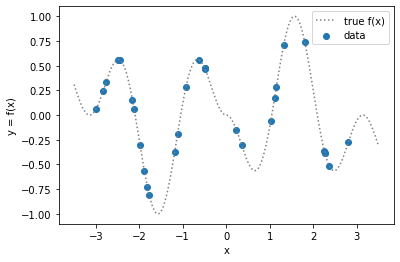

In [4]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Plot data and true function.
plt.scatter(simdata['x'], simdata['f'], label='data')
plt.plot(simdata['x_true'], simdata['f_true'], ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

# Store data as torch.tensors.
X = np.array(simdata['x'])
y = np.array(simdata['f'])

In [5]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# NOTE: num_leapfrog = trajectory_length / step_size
kernel = HMC(GP, step_size=.01, trajectory_length=1) 

hmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
hmc.run(rng_key, X, y)

hmc_samples = hmc.get_samples()
hmc_samples = dict(alpha=np.sqrt(hmc_samples['kernel_var']), rho=hmc_samples['kernel_length'])

sample: 100%|██████████| 2000/2000 [00:05<00:00, 363.28it/s, 1 steps of size 8.32e-01. acc. prob=0.92]


CPU times: user 12.8 s, sys: 6.24 s, total: 19.1 s
Wall time: 8.76 s


In [6]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# Set up NUTS sampler.
kernel = NUTS(GP, max_tree_depth=10, target_accept_prob=0.8)

nuts = MCMC(kernel, num_samples=1000, num_warmup=1000)
nuts.run(rng_key, X, y)

nuts_samples = hmc.get_samples()
nuts_samples = dict(alpha=np.sqrt(nuts_samples['kernel_var']), rho=nuts_samples['kernel_length'])

sample: 100%|██████████| 2000/2000 [00:07<00:00, 255.53it/s, 3 steps of size 9.42e-01. acc. prob=0.90] 


CPU times: user 13.7 s, sys: 5.79 s, total: 19.5 s
Wall time: 8.9 s


../util/gp_plot_util.py:26: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu, S)


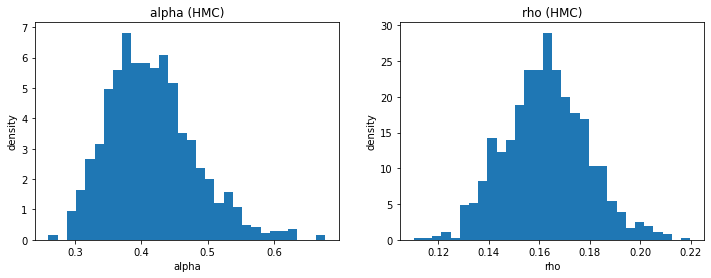

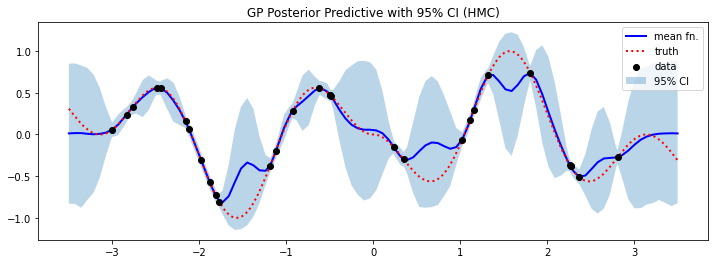

In [7]:
# Plot posterior for HMC
gp_plot_util.make_plots(hmc_samples, suffix="HMC",
                        x=np.array(simdata['x']), y=np.array(simdata['f']),
                        x_true=simdata['x_true'], f_true=simdata['f_true'])

../util/gp_plot_util.py:26: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu, S)


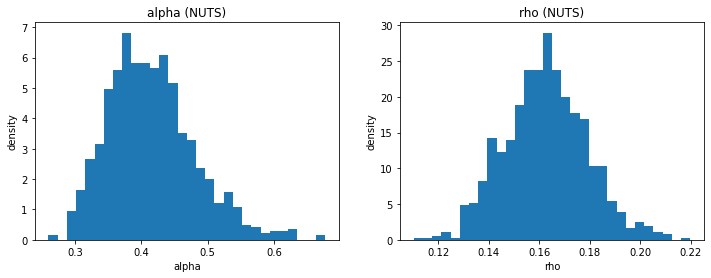

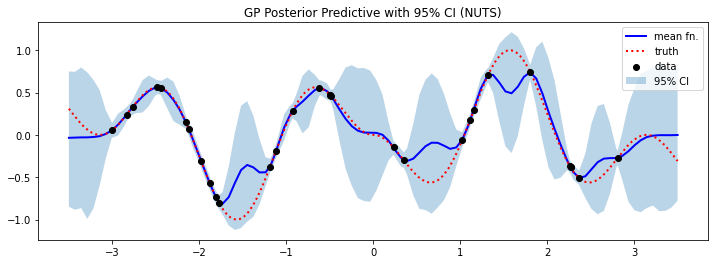

In [8]:
# Plot posterior for NUTS
gp_plot_util.make_plots(hmc_samples, suffix="NUTS",
                        x=np.array(simdata['x']), y=np.array(simdata['f']),
                        x_true=simdata['x_true'], f_true=simdata['f_true'])